In [1]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set_style('ticks')
import matplotlib.font_manager
for font in matplotlib.font_manager.findSystemFonts(
    '/Users/deepak/Library/Fonts/'):
    matplotlib.font_manager.fontManager.addfont(font)
font = {
    'font.family':'Roboto',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
import ast
import os
import re
from sklearn.linear_model import LinearRegression

# Read runtimes from logfiles

In [3]:
def read_all_logfiles_in_directory(logfile_directory):
    runtimes = {}
    for logfile_name in os.listdir(logfile_directory):
        model = logfile_name.replace(".log", "")
        logfile_full_path = os.path.join(logfile_directory, logfile_name)
        with open(logfile_full_path, 'r') as f:
            for line in f:
                m = re.match(r'Runtime for (.*): (\d+\.\d+) seconds', line)
                if m is not None:
                    label = ast.literal_eval(m.group(1))
                    label['model'] = model
                    runtime = float(m.group(2))
                    runtimes[(label['model'], label['num_input_tokens'],
                              label['num_output_tokens'])] = runtime
    return runtimes

In [4]:
v100_runtimes = read_all_logfiles_in_directory("logs/v100")
a100_runtimes = read_all_logfiles_in_directory("logs/a100")

# Plot runtimes for each model

In [5]:
def plot_per_model_runtimes(runtimes, model, all_num_input_tokens):
    print(model)

    plt.figure(figsize=(10, 4.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    for num_input_tokens in all_num_input_tokens:
        num_output_tokens_and_runtimes = []
        for label, runtime in runtimes.items():
            if label[0] == model and label[1] == num_input_tokens:
                num_output_tokens_and_runtimes.append((label[2], runtime))
        ax.plot([x for (x, _) in num_output_tokens_and_runtimes],
                [y for (_, y) in num_output_tokens_and_runtimes],
                label=f"input_tokens={num_input_tokens}",
                marker='o')

    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.set_xlabel("Number of output tokens")
    ax.set_ylabel("Runtime (seconds)")
    plt.legend(frameon=False)    
    sns.despine()
    plt.show()

gptj_6b


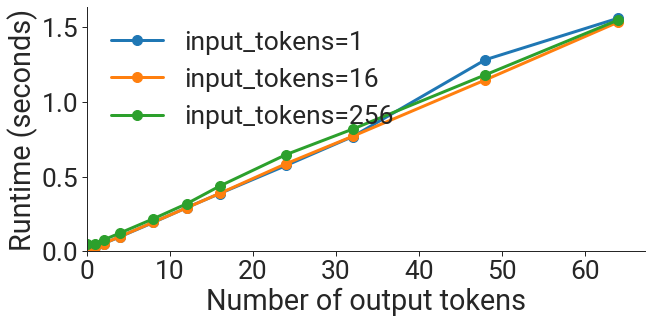

openai_ada


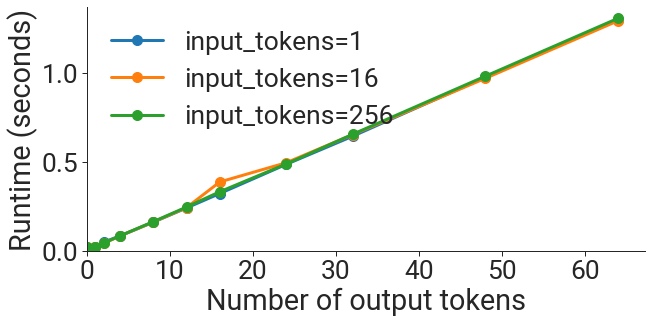

openai_davinci


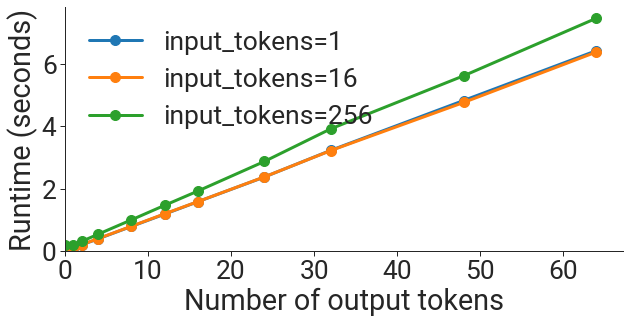

ai21_j1_jumbo


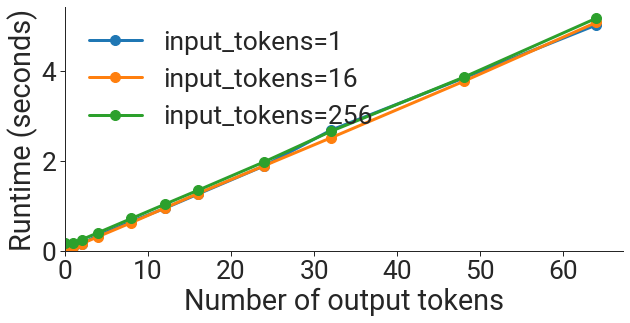

In [6]:
# Plot V100 runtimes.
plot_per_model_runtimes(v100_runtimes, 'gptj_6b', [1, 16, 256])
plot_per_model_runtimes(v100_runtimes, 'openai_ada', [1, 16, 256])
plot_per_model_runtimes(v100_runtimes, 'openai_davinci', [1, 16, 256])
plot_per_model_runtimes(v100_runtimes, 'ai21_j1_jumbo', [1, 16, 256])

gptj_6b


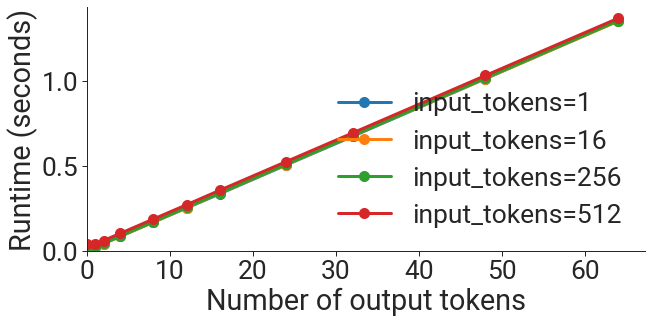

openai_ada


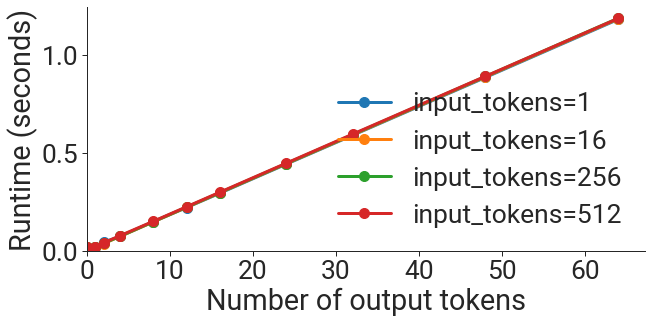

openai_davinci


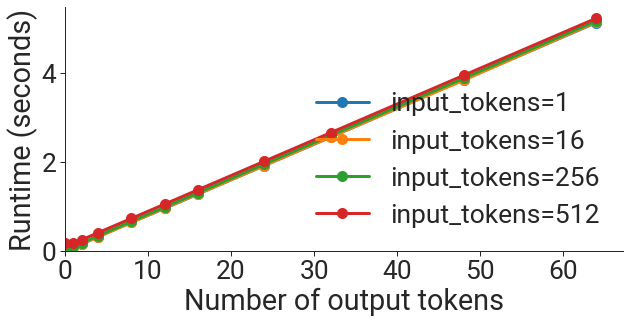

ai21_j1_jumbo


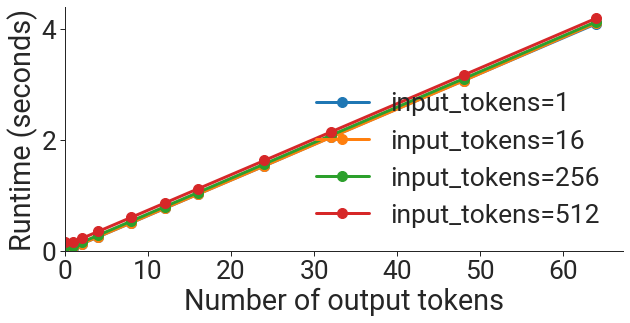

In [7]:
# Plot A100 runtimes.
plot_per_model_runtimes(a100_runtimes, 'gptj_6b', [1, 16, 256, 512])
plot_per_model_runtimes(a100_runtimes, 'openai_ada', [1, 16, 256, 512])
plot_per_model_runtimes(a100_runtimes, 'openai_davinci', [1, 16, 256, 512])
plot_per_model_runtimes(a100_runtimes, 'ai21_j1_jumbo', [1, 16, 256, 512])

# Plot runtimes for each number of input tokens

In [8]:
def plot_per_num_input_tokens_runtimes(runtimes, models, num_input_tokens):
    print(f"Number of input tokens: {num_input_tokens}")

    plt.figure(figsize=(10, 4.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    for model in models:
        num_output_tokens_and_runtimes = []
        for label, runtime in runtimes.items():
            if label[0] == model and label[1] == num_input_tokens:
                num_output_tokens_and_runtimes.append((label[2], runtime))
        ax.plot([x for (x, _) in num_output_tokens_and_runtimes],
                [y for (_, y) in num_output_tokens_and_runtimes],
                label=f"{model}",
                marker='o')

    ax.set_xlim(0, None)
    ax.set_ylim(0, 7)
    ax.set_xlabel("Number of output tokens")
    ax.set_ylabel("Runtime (seconds)")
    plt.legend(frameon=False, loc='upper left', ncol=2)    
    sns.despine()
    plt.show()

Number of input tokens: 1


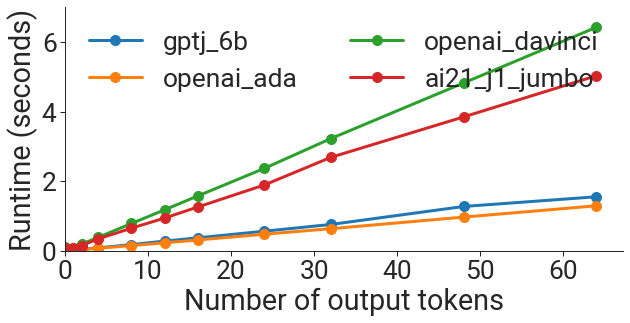

Number of input tokens: 16


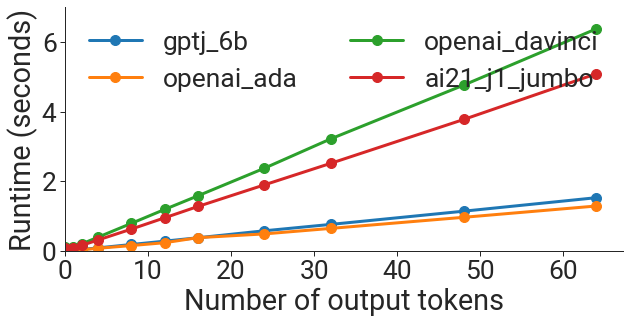

Number of input tokens: 256


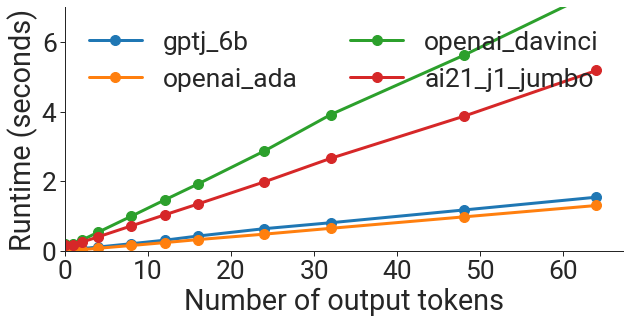

In [9]:
# Plot V100 runtimes.
models = ["gptj_6b", "openai_ada", "openai_davinci", "ai21_j1_jumbo"]
plot_per_num_input_tokens_runtimes(v100_runtimes, models, 1)
plot_per_num_input_tokens_runtimes(v100_runtimes, models, 16)
plot_per_num_input_tokens_runtimes(v100_runtimes, models, 256)

Number of input tokens: 1


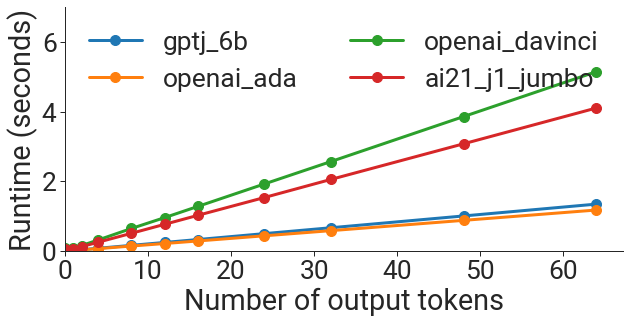

Number of input tokens: 16


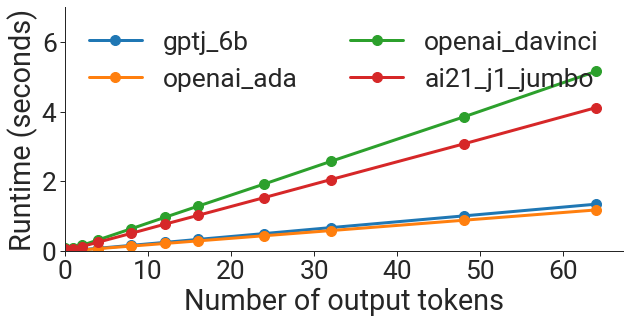

Number of input tokens: 256


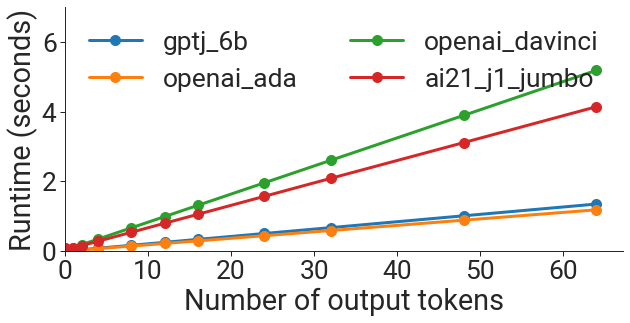

Number of input tokens: 512


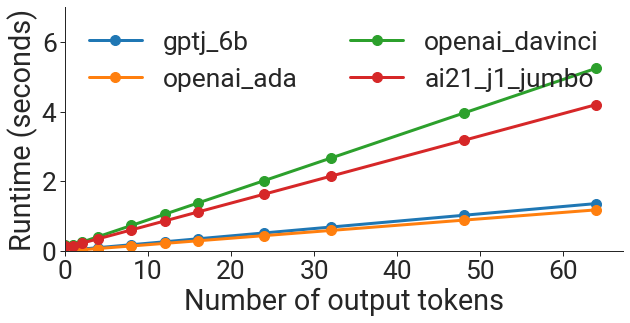

In [10]:
# Plot A100 runtimes.
models = ["gptj_6b", "openai_ada", "openai_davinci", "ai21_j1_jumbo"]
plot_per_num_input_tokens_runtimes(a100_runtimes, models, 1)
plot_per_num_input_tokens_runtimes(a100_runtimes, models, 16)
plot_per_num_input_tokens_runtimes(a100_runtimes, models, 256)
plot_per_num_input_tokens_runtimes(a100_runtimes, models, 512)

# Get best-fit lines (slope and intercept)

In [11]:
import numpy as np

def compute_best_fit(runtimes, models):
    for model in models:
        # Get all unique num_input_tokens.
        all_num_input_tokens = set()
        for label in runtimes:
            all_num_input_tokens.add(label[1])
        all_num_input_tokens = sorted(list(all_num_input_tokens))
        
        # Group runtimes by num_input_tokens.
        processed_runtimes = [[] for num_input_tokens in all_num_input_tokens]
        for i, num_input_tokens in enumerate(all_num_input_tokens):
            for label, runtime in runtimes.items():
                if label[0] == model and label[1] == num_input_tokens:
                    processed_runtimes[i].append((label[2], runtime))
                    
        # Compute average runtime difference between configurations
        # using n input tokens and 1 input token, and the same number
        # of generated output tokens.
        runtime_differences = [0]
        for i in range(1, len(all_num_input_tokens)):
            average_runtime_difference = np.mean([processed_runtimes[i][j][1] - processed_runtimes[0][j][1]
                                                  for j in range(len(processed_runtimes[0]))])
            runtime_differences.append(average_runtime_difference)

        # Perform regression between adjusted runtimes and number of
        # output tokens, to obtain the runtime per generated output
        # token and the runtime for embedding a prompt with a single
        # token.
        num_output_tokens_and_runtimes = []
        for i, num_input_tokens in enumerate(all_num_input_tokens):
            for label, runtime in runtimes.items():
                if label[0] == model and label[1] == num_input_tokens:
                    num_output_tokens_and_runtimes.append((label[2], runtime - runtime_differences[i]))
        X = [[x] for (x, _) in num_output_tokens_and_runtimes]
        Y = [y for (_, y) in num_output_tokens_and_runtimes]
        reg = LinearRegression()
        reg.fit(X, Y)
        cost_per_output_token = reg.coef_[0]
        cost_one_input_tokens = reg.intercept_
        print(f"{model}:\n\tcost per output token = {cost_per_output_token:.3f}")
        for i, num_input_tokens in enumerate(all_num_input_tokens):
            cost_all_input_tokens = cost_one_input_tokens + runtime_differences[i]
            print(f"\tcost for {num_input_tokens} input token(s) = {cost_all_input_tokens:.3f}")
    print()

In [12]:
# Compute best fit for V100 runtimes.
models = ["gptj_6b", "openai_ada", "openai_davinci", "ai21_j1_large", "ai21_j1_jumbo"]
compute_best_fit(v100_runtimes, models)

gptj_6b:
	cost per output token = 0.024
	cost for 1 input token(s) = 0.020
	cost for 16 input token(s) = 0.007
	cost for 32 input token(s) = 0.005
	cost for 64 input token(s) = 0.012
	cost for 128 input token(s) = 0.018
	cost for 192 input token(s) = 0.025
	cost for 256 input token(s) = 0.039
	cost for 320 input token(s) = 0.043
	cost for 384 input token(s) = 0.048
	cost for 428 input token(s) = 0.072
	cost for 472 input token(s) = 0.073
	cost for 512 input token(s) = 0.067
openai_ada:
	cost per output token = 0.020
	cost for 1 input token(s) = 0.004
	cost for 16 input token(s) = 0.010
	cost for 32 input token(s) = 0.003
	cost for 64 input token(s) = 0.009
	cost for 128 input token(s) = 0.006
	cost for 192 input token(s) = 0.009
	cost for 256 input token(s) = 0.008
	cost for 320 input token(s) = 0.009
	cost for 384 input token(s) = 0.021
	cost for 428 input token(s) = 0.014
	cost for 472 input token(s) = 0.017
	cost for 512 input token(s) = 0.013
openai_davinci:
	cost per output token 

In [13]:
# Compute best fit for A100 runtimes.
models = ["gptj_6b", "openai_ada", "openai_davinci", "ai21_j1_large", "ai21_j1_jumbo"]
compute_best_fit(a100_runtimes, models)

gptj_6b:
	cost per output token = 0.021
	cost for 1 input token(s) = 0.005
	cost for 16 input token(s) = 0.006
	cost for 32 input token(s) = 0.005
	cost for 64 input token(s) = 0.006
	cost for 128 input token(s) = 0.006
	cost for 192 input token(s) = 0.007
	cost for 256 input token(s) = 0.008
	cost for 320 input token(s) = 0.012
	cost for 384 input token(s) = 0.014
	cost for 428 input token(s) = 0.023
	cost for 472 input token(s) = 0.023
	cost for 512 input token(s) = 0.024
openai_ada:
	cost per output token = 0.018
	cost for 1 input token(s) = 0.005
	cost for 16 input token(s) = 0.006
	cost for 32 input token(s) = 0.004
	cost for 64 input token(s) = 0.005
	cost for 128 input token(s) = 0.005
	cost for 192 input token(s) = 0.006
	cost for 256 input token(s) = 0.007
	cost for 320 input token(s) = 0.008
	cost for 384 input token(s) = 0.008
	cost for 428 input token(s) = 0.009
	cost for 472 input token(s) = 0.008
	cost for 512 input token(s) = 0.009
openai_davinci:
	cost per output token 